In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import pmdarima as pm

In [2]:
df = pd.read_csv("../DataSets/bitcoin_technical_5Y.csv")
df

,date,open,high,low,close,volume,RSI,RS,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
0,2018-04-25,9701.030273,9745.320313,8799.839844,8845.740234,11083100160,0.000000,0.000000,-19.109995,-10.616664,-8.493331,10476.190330,9271.620117,8067.049904
1,2018-04-26,8867.320313,9281.509766,8727.089844,9281.509766,8970559488,38.039560,0.613933,-10.836739,-10.706859,-0.129881,10126.752981,9274.916667,8423.080353
2,2018-04-27,9290.629883,9375.469727,8987.049805,8987.049805,7566289920,29.072209,0.409885,-17.439684,-12.987626,-4.452058,9955.689880,9202.949951,8450.210022
3,2018-04-28,8939.269531,9412.089844,8931.990234,9348.480469,7805479936,47.352603,0.899429,-6.278319,-10.991759,4.713440,9896.816429,9232.056055,8567.295680
4,2018-04-29,9346.410156,9531.490234,9193.709961,9419.080078,8853000192,50.351971,1.014179,3.568068,-7.045236,10.613304,9877.102724,9263.226725,8649.350727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2023-04-20,28823.683594,29076.400391,28037.257813,28245.988281,21340360360,32.300373,0.477113,688.721458,927.692397,-238.970939,31173.681929,29072.722949,26971.763970
1822,2023-04-21,28249.230469,28349.968750,27177.365234,27276.910156,20759504330,24.716457,0.328312,472.983978,836.750713,-363.766735,31249.231841,29016.016699,26782.801557
1823,2023-04-22,27265.894531,27872.142578,27169.570313,27817.500000,13125734602,34.941810,0.537085,341.692733,737.739117,-396.046384,31265.780752,28996.926270,26728.071787
1824,2023-04-23,27816.144531,27820.244141,27400.314453,27591.384766,12785446832,32.711708,0.486143,216.897604,633.570814,-416.673210,31279.719450,28986.984473,26694.249496


In [3]:
df = df[df.columns[0:5]]
del df['open']
del df['high']
del df['low']
df_origin = df.copy()
df_origin

,date,close
0,2018-04-25,8845.740234
1,2018-04-26,9281.509766
2,2018-04-27,8987.049805
3,2018-04-28,9348.480469
4,2018-04-29,9419.080078
...,...,...
1821,2023-04-20,28245.988281
1822,2023-04-21,27276.910156
1823,2023-04-22,27817.500000
1824,2023-04-23,27591.384766


### Test for stationary

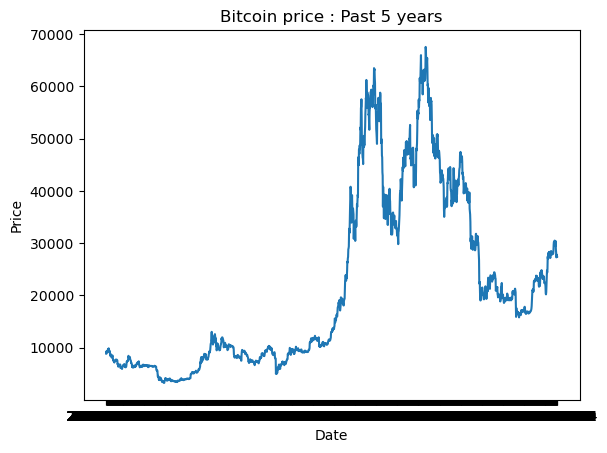

In [4]:
#Visualize data 
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price : Past 5 years')
plt.show()

In [5]:
##Reduce Variance using log
df['close'] = np.log(df['close'])

C:\Users\mango\AppData\Local\Temp\ipykernel_18180\3593280324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = np.log(df['close'])


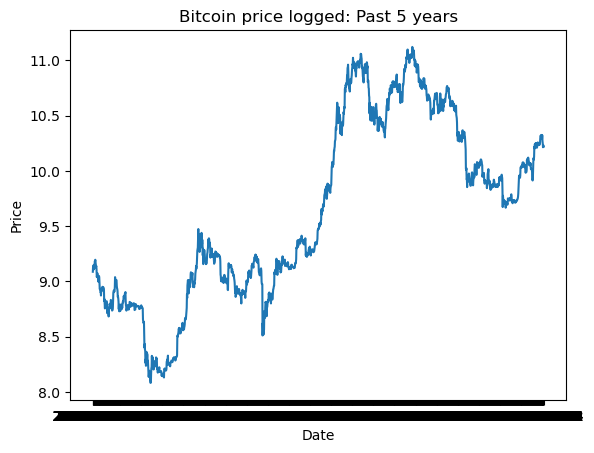

In [6]:
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price logged: Past 5 years')
plt.show()

### Differencing the data according to ARIMA conditions

In [7]:
def adf_test(target_series):
    """
    Parameters
    ----------
    target_series : Pandas Series
        The column of dataframe that contains the target data to which
        we want to test for stationarity e.g. Bitcoin Price.
    Returns
    -------
    adf_statistic : Float
        The adf statistic.
    p_value : Float
        The p value of the adf test.
    """
    result = adfuller(target_series)
    adf_statistic = result[0]
    p_value = result[1]
    print('ADF Statistic: %f' % adf_statistic)
    print('p-value: %f' % p_value)
    return adf_statistic, p_value

In [8]:
adf_test(df['close'])

ADF Statistic: -0.963393
p-value: 0.766381


(-0.9633926430287286, 0.7663808187094759)

In [9]:
p_value = 0.768296

In [10]:
def kpss_test(target_series):
    print("Results of KPSS Test:")
    kpsstest = kpss(target_series, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [11]:
kpss_test(df['close'])

Results of KPSS Test:
Test Statistic            0.734965
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


C:\Users\mango\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [12]:
def find_order_of_differencing(df):
    """
    Parameters
    ----------
    df : DataFrame
        cleaned time series data of the respective currency.
    Returns
    -------
    d : INT
        An integar representing the number of differences to get time
        series stationary. When P value is < 0.05 from augmented
        dicky fuller test function will return d.
    """
    # get the adf statistic and p values
    adf_statistic, p_value = adf_test(df['close'])
    # get kpss statiostic and p value
    kpss_test(df['close'])
    # p value needs to be < 0.05 for time series to be stationary
    if p_value > 0.05:
        # set number of differences to 0
        d = 0
        # if p value is above threshold repeatedly run logic until below
        while p_value > 0.05:
            print("")
            print("")
            print("P value to large, trying differencing")
            # difference the time series
            df['close'] = df['close'].diff()
            # drop the null values
            df.dropna(inplace = True)
            # add 1 to d for each iteration to represent 1 differencing
            d += 1
            # perform adf test again to asses p value and exit loop if stationary
            adf_statistic, p_value = adf_test(df['close'])
            # perform KPSS test
            kpss_test(df['close'])
        print(f"Success... TS now stationary after {d} differncing")
        return df

In [13]:
df = find_order_of_differencing(df)

ADF Statistic: -0.963393
p-value: 0.766381
Results of KPSS Test:
Test Statistic            0.734965
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


P value to large, trying differencing
ADF Statistic: -19.988476
p-value: 0.000000
Results of KPSS Test:
Test Statistic           0.145515
p-value                  0.050898
Lags Used                9.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64
Success... TS now stationary after 1 differncing


C:\Users\mango\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\mango\AppData\Local\Temp\ipykernel_18180\911645095.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = df['close'].diff()
C:\Users\mango\AppData\Local\Temp\ipykernel_18180\911645095.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [14]:
df

,date,close
1,2018-04-26,0.048088
2,2018-04-27,-0.032240
3,2018-04-28,0.039429
4,2018-04-29,0.007524
5,2018-04-30,-0.019136
...,...,...
1821,2023-04-20,-0.020211
1822,2023-04-21,-0.034911
1823,2023-04-22,0.019625
1824,2023-04-23,-0.008162


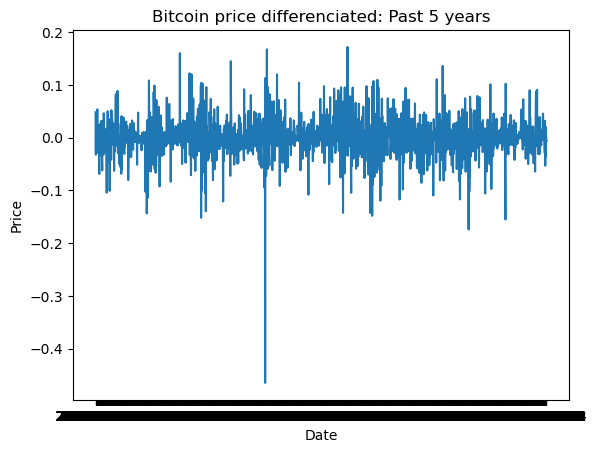

In [15]:
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price differenciated: Past 5 years')
plt.show()

In [16]:
def auto_arima(orig_df):
    """
    Parameters
    ----------
    orig_df : Data Frame
        Copied data frame from origonal read in prior to manual differencing.
    Returns
    -------
    model.order: Tuple
        tuple of found p,q,q values from auto arima
    differenced_by_auto_arima: Data Frame
        the differenced data frame output from the auto arima function
    fitted_residuals: The residuals of the fitted model.
    """
    #get target series
    orig_df = np.log(orig_df['close'])
    model = pm.auto_arima(orig_df,
                          start_p=10,
                          start_q=10,
                          test='adf',
                          max_p=10, 
                          max_q=10, 
                          m=1,
                          d=None,           
                          seasonal=False,   
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,
                         stepwise = True)
    # difference df by d found by auto arima
    differenced_by_auto_arima = orig_df.diff(model.order[1])
    return model.order, differenced_by_auto_arima, model.resid()

In [17]:
model_order, differenced_data, model_residuals = auto_arima(df_origin)

Performing stepwise search to minimize aic
 ARIMA(10,1,10)(0,0,0)[0] intercept   : AIC=-6848.458, Time=4.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6868.135, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6870.179, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6869.836, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6869.618, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6871.819, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6869.848, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6869.917, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6872.403, Time=1.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6869.696, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6871.520, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6870.193, Time=2.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6872.808, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6871.272, Time=0.08 sec
 ARIMA(1,1,0)(0,0